In [200]:
# packages
import pandas as pd
# import pyarrow.dataset as ds
# import pyarrow as pa
# from datasets import *
# from transformers import *
from tokenizers import *
import os
import json
import sys
# from tokenizers.processors import BertProcessing
import numpy as np

In [201]:
# INPORTANT
# out_dir = './task_devign_v3'
# raw_data_path = '/scratch/xin/devign_task/tokenized_devign_v3.pkl'
MAX_LENGTH = 1024
batch_size = 8 # 32 when max_length = 512
# model_path = '/scratch/xin/bert_source_v3/pretrained-bert/'
num_epochs = 1
max_step_saves = 5
save_step_at = 20
learning_rate = 1e-5
adam_epsilon = 1e-8


test_only = False
data_type = 'devign'
data_dir = "/scratch/dna_data_pretraining_2/{}".format(data_type)
out_dir = 'result_{}_{}_with_tagging'.format(data_type, MAX_LENGTH)

bert_model_path = '/scratch/pretrained-dna-bert/checkpoint-35000'
tokenizer_path = '/scratch/pretrained-dna-bert/'
truncate_longer_samples = True


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
log_txt_file = os.path.join(out_dir, 'log.txt')
# intialization
with open(log_txt_file, 'w+') as f:
    f.write('- log -\n')

def log_txt(s, type='normal'):
    with open(log_txt_file, 'a') as f:
        f.write('{} - {}\n'.format( type, s))

In [202]:
# load data
from sklearn.model_selection import train_test_split

def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'type': [], 'label': []}
    for i in range(len(raw_df['code'][:100])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split(';')
        code = ' '.join(code)
        df['text'].append(code)
        df['label'].append(raw_df['label'][i])
        df['type'].append(raw_df['type'][i])
    df = pd.DataFrame(df)
    return df
    ### convert to Huggingface dataset
#     return Dataset(pa.Table.from_pandas(df))

# random split into train/valid/test
if data_type in ['devign']:
    raw_data_path = os.path.join(data_dir, 'all.pkl')
    tokenized_data = get_data(raw_data_path)
    print(len(tokenized_data))
    train_data, valid_data, test_data = np.split(tokenized_data, [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])
# load train/valid/test
elif data_type in ['mvdsc', 'd2a' ]:
        train_data = get_data(os.path.join(data_dir, 'train.pkl'))
        valid_data = get_data(os.path.join(data_dir, 'valid.pkl'))
        test_data = get_data(os.path.join(data_dir, 'test.pkl'))
# load train/valid/test from 4 types
elif data_type in ['sysevr']:
    # already randomized from pre-processing with fixed seed for pre-training and fine-tuning
    raw_data_path = os.path.join(data_dir, 'api.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_1, valid_data_1, test_data_1 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    raw_data_path = os.path.join(data_dir, 'au.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_2, valid_data_2, test_data_2 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    raw_data_path = os.path.join(data_dir, 'ae.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_3, valid_data_3, test_data_3 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    raw_data_path = os.path.join(data_dir, 'pu.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data_4, valid_data_4, test_data_4 = np.split(tokenized_data, [int(.7*len(tokenized_data)), int(.85*len(tokenized_data))])
    tokenized_data = get_data(raw_data_path)
    train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4], ignore_index=True)
    valid_data = pd.concat([valid_data_1, valid_data_2, valid_data_3, valid_data_4], ignore_index=True)
    test_data = pd.concat([test_data_1, test_data_2, test_data_3, test_data_4], ignore_index=True)
elif  data_type in ['draper']:
    # splitted data bc too large
    all_data = {}
    for i in range(10):
        raw_data_path = os.path.join(data_dir, 'train_{}.pkl'.format(i))
        tokenized_data = get_data(raw_data_path)
        #train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4], ignore_index=True)

else:
    print('data type does not exist!')


100


In [203]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data['text'][0])
print(train_data['type'][0])
log_txt('train: {} - valid: {} - test: {} '.format(len(train_data), len(valid_data), len(test_data)))

(80, 4)
(10, 4)
(10, 4)
int Function0 ( AVDictionary * AVDictionaryPoParCalPas , AVOpenCLExternalEnv * AVOpenCLExternalEnvPoParCalPas ) { int intDefUsePasRet = 0   AVDictionaryEntry * AVDictionaryEntryPoDefUseCalPas   AVDictionaryEntry * AVDictionaryEntryPoDefUseCalPas1   AVDictionaryEntry * AVDictionaryEntryPoDefUseCalPas2   LOCK_OPENCL if ( ! gpu_env . init_count ) { AVDictionaryEntryPoDefUseCalPas1 = av_dict_get ( AVDictionaryPoParCalPas , DQ 1 2 , NULL , 0 )   AVDictionaryEntryPoDefUseCalPas2 = av_dict_get ( AVDictionaryPoParCalPas , DQ 1 0 , NULL , 0 )   gpu_env . usr_spec_dev_info . platform_idx = - 1   gpu_env . usr_spec_dev_info . dev_idx = - 1   if ( AVDictionaryEntryPoDefUseCalPas1 ) { gpu_env . usr_spec_dev_info . platform_idx = strtol ( AVDictionaryEntryPoDefUseCalPas1 -> value , NULL , 1 0 )   } if ( AVDictionaryEntryPoDefUseCalPas2 ) { gpu_env . usr_spec_dev_info . dev_idx = strtol ( AVDictionaryEntryPoDefUseCalPas2 -> value , NULL , 1 0 )   } intDefUsePasRet = init_openc

In [204]:
# from gensim.test.utils import common_texts
# from gensim.models import Word2Vec

word2vec_train_text = []
for i in range(len(train_data['type'])):
    text = train_data['type'][i]
    for st in ['(', ')', ':', ';']:
        text = text.replace(st, ' {} '.format(st))
    text = text.split()
    word2vec_train_text.append(text)

vector_size = 16
word2vec_model = Word2Vec(sentences=word2vec_train_text, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=3)
word2vec_model.save("word2vec.model")



In [205]:

# contains the list of all unique words in pre-trained word2vec vectors
words = list(word2vec_model.wv.index_to_key)
print(len(words))
# print(words)

102


(40, 16)


/scratch/conda_envs/dna/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/conda_envs/dna/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(40, 2)


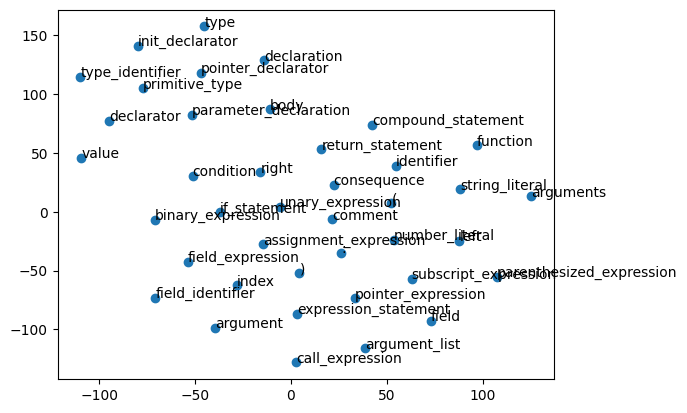

In [206]:
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt

vocab = list(word2vec_model.wv.key_to_index)
vocab = vocab[:40]
X = word2vec_model.wv[vocab]

print(X.shape)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

print(X_tsne.shape)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)
    
plt.show() 
# fig.savefig("../text.png")

In [207]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]
label_values

[0, 1]

In [208]:
def convert_types(type_list):
    word2vec_train_text = []
    for i in range(len(type_list)):
        text = train_data['type'][i]
        for st in ['(', ')', ':', ';']:
            text = text.replace(st, ' {} '.format(st))
        text = text.split()
        word2vec_train_text.append(text)
    return word2vec_train_text 

train_texts = train_data['text'].values
train_types = train_data['type'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_types = valid_data['type'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_types = test_data['type'].values
test_labels = test_data['label'].values


train_types = convert_types(train_types)
valid_types = convert_types(valid_types)
test_types = convert_types(test_types)




In [209]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
log_txt('min: {}'.format(min(text_lengths)))
log_txt('min: {}'.format(min(text_lengths)))
log_txt('number of zeros:: {}'.format(len([item for item in text_lengths if item == 0])))
log_txt('max: {}'.format(max(sorted(text_lengths))))
log_txt('avg: {}'.format( sum(text_lengths) / len(text_lengths) ))
log_txt('median: {}'.format( sorted(text_lengths)[len(text_lengths) // 2] ))
log_txt('95%: {}'.format( sorted(text_lengths)[int(len(text_lengths)*0.95)]))
log_txt('mean: {}'.format( statistics.mean(text_lengths)))
log_txt('std: {}'.format( statistics.stdev(text_lengths)))
    

/tmp/ipykernel_352/280788245.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


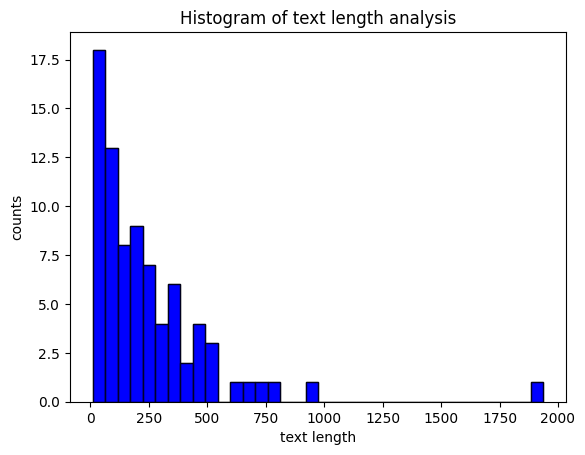

In [210]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')
plt.savefig(os.path.join(out_dir, 'histogram.png'))

In [211]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

1

In [212]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 32010
# maximum sequence length, lowering will result to faster training (when increasing batch size)
import sentencepiece as spm
import transformers 
# !pip install sentencepiece

from tokenizers import SentencePieceBPETokenizer

if 'albert' in tokenizer_path:
    tokenizer = transformers.AlbertTokenizer.from_pretrained(tokenizer_path)
else:
    tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_path)

log_txt('tokenizer_path: {}\n'.format( tokenizer_path))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [213]:
# text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]
if not truncate_longer_samples:
    #tokenizer(examples["text"], return_special_tokens_mask=True)
    train_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in test_texts]
else:
    max_length = MAX_LENGTH
    train_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in valid_texts]

    test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in test_texts]

In [214]:
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]
# text_ids[0]

train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# att_masks[0]

# print(word2vec_model.wv[[')', '(']])
lambda a,i : a[0:i] if len(a) > i else a + [0] * (i-len(a))

def word2vec_trunction(input_types):
    train_types_np = []
    for one_slice in input_types:
        if len(one_slice) > max_length:
            one_slice = one_slice[:max_length]
        slice_vec = word2vec_model.wv[one_slice]
        slice_vec = np.array(slice_vec)
        shape = np.shape(slice_vec)
        padded_array = np.zeros((max_length, vector_size))
        padded_array[:shape[0],:shape[1]] = slice_vec
        train_types_np.append(padded_array)
    return np.array(train_types_np)

train_types_np = word2vec_trunction(train_types)
valid_types_np = word2vec_trunction(valid_types)
test_types_np = word2vec_trunction(test_types)

print(train_types_np.shape)
print(valid_types_np.shape)
print(test_types_np.shape)

(80, 1024, 16)
(10, 1024, 16)
(10, 1024, 16)


In [215]:
from sklearn.model_selection import train_test_split
train_x, train_m, train_t, train_y = train_text_ids, train_att_masks, train_types_np, train_labels
val_x, val_m, val_t, val_y = valid_text_ids, valid_att_masks,valid_types_np,  valid_labels
test_x, test_m, test_t, test_y = test_text_ids, test_att_masks, test_types_np, test_labels

In [216]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)
train_t = torch.tensor(train_t)
val_t = torch.tensor(val_t)
test_t = torch.tensor(test_t)

log_txt(train_x.shape)
log_txt(test_x.shape)
log_txt(val_x.shape)
log_txt(test_y.shape)
log_txt(val_y.shape)
log_txt(train_m.shape)
log_txt(test_m.shape)
log_txt(val_m.shape)
log_txt(train_t.shape)
log_txt(val_t.shape)
log_txt(test_t.shape)

In [217]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# log_txt(train_x)
train_data = TensorDataset(train_x, train_m, train_t, train_y)
train_sampler = list(range(len(train_data)))


# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_x, val_m, val_t, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



# train_loader_extracted = torch.utils.data.DataLoader(train_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=train_sampler)


# valid_loader_extracted = torch.utils.data.DataLoader(valid_extracted_data, batch_size=batch_size, shuffle=False,
#                                            sampler=val_sampler)


In [268]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys


os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 

class DotAttention(nn.Module):

    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn_vector = nn.Parameter(
            torch.Tensor(1, hidden_size), requires_grad=True)
        init.xavier_uniform(self.attn_vector.data)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths=None):
        batch_size, max_len = inputs.size()[:2]
        '''
        print("INPUTS", inputs.size())
        print("ATTN", self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, hidden_size, 1)
                            .transpose(2, 1)
                            .repeat(batch_size, 1, 1).size())'''
        # apply attention layer
        weights = torch.bmm(inputs,
                            self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, 1, hidden_size)
                            .transpose(2, 1) # (1, hidden_size, 1)
                            .repeat(batch_size, 1, 1)) # (batch_size, hidden_size, 1))
        attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
        # create mask based on the sentence lengths
        #idxes = torch.arange(0, max_len, out=torch.LongTensor(max_len)).unsqueeze(0).cuda()  # some day, you'll be able to directly do this on cuda
        #mask = Variable((idxes < lengths.data.unsqueeze(1)).float())
        # apply mask and renormalize attention scores (weights)
        #masked = attn_weights * mask
        _sums = attn_energies.sum(-1).unsqueeze(1).expand_as(attn_energies)  # sums per row
        attn_weights = attn_energies / _sums
        # print('attn_weights: ', attn_weights.shape)
        # apply attention weights
        weighted = torch.mul(inputs, attn_weights.unsqueeze(-1).expand_as(inputs))
        # print('weighted: ', weighted.shape)
        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()
        if len(representations.shape) == 1:
            representations = representations.reshape(1, representations.shape[-1])
        # print('representations: ', representations.shape)
        return representations, attn_weights
    
from transformers import AutoModelForSequenceClassification
    
class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
#         self.model = BertForMaskedLM.from_pretrained(checkpoint)
        #Load Model with given checkpoint and extract its body
        # self.model = AutoModelForSequenceClassification.from_pretrained(bert_model_path, num_labels=2)
        
        # classifier with pre-training model 
        self.model  = transformers.AutoModel.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True)
        self.attn = DotAttention(hidden_size = 768)
        self.hidden_size = 128
        self.classifier = nn.Linear(768 * 2, self.hidden_size) # load and initialize weights
        self.relu = nn.ReLU() #ReLU()

        # classifier with word2vec output from types
        # [batch_size, max_length, word_dim]  ex. 4 * 1024 * 16
        # self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.n_layers = 2
        self.h = self.init_hidden(batch_size // multi_gpu)
        self.gru = nn.GRU(vector_size, self.hidden_size, self.n_layers, batch_first=True, dropout=0.2)
        
        self.dropout = nn.Dropout(0.25)
        self.final_classifier = nn.Linear(self.hidden_size * (MAX_LENGTH // 512), num_labels) 
        self.activation = nn.Sigmoid()
        
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_size).zero_()
        return hidden
    
    def forward_single(self, input_ids, attention_mask, type_vec, labels, ex):
        all_outputs = self.model(input_ids, attention_mask=attention_mask)
        hidden_states = all_outputs[0]
        pooler_output = all_outputs[1]
        attention_weights = all_outputs[3]
        #print(type_vec.shape)
        
        out, _ = self.gru(type_vec, self.h)
        out = self.relu(out[:,-1])
                        
        # outputs = outputs
        # hidden_states, pool_output, unknown, attention_weights
        # pooler_output = hidden_states[:, 0, :]
        # max + last + attention START
        # last =  hidden_states[:,-1] 
        attn, attention_weights_dot_product = self.attn.forward(hidden_states)
        # max_ , _ = torch.max(hidden_states, dim=1)
        concatenated = torch.cat([attn, pooler_output], dim=1)
        
        
        logits = self.classifier(concatenated)
        
        return self.relu(logits), attention_weights_dot_product
    
    def forward(self, input_ids=None, attention_mask=None, type_vec=None, labels=None, ex=None, max_len=MAX_LENGTH, opt='mean'):
        #Extract outputs from the body
        final_logits = None
        final_attention_weights = None
        # pick the most suspicous one for final decision
        for i in range(0, max_len, 512):
            logits, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], type_vec, labels, ex)
            if final_logits is None:
                final_logits = logits
                final_attention_weights = attention_weights
            else:
                final_logits = torch.cat([final_logits,  logits], dim=1)
                final_attention_weights = torch.cat([final_attention_weights,  attention_weights], dim=1)

        final_logits = self.dropout(final_logits)
        final_logits = self.final_classifier(final_logits)
        final_logits = self.activation(final_logits)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(final_logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, final_logits), final_attention_weights


        #return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [269]:
log_txt(bert_model_path)
model = BERTSourceBinaryClassification(checkpoint=bert_model_path, num_labels=2)

Some weights of the model checkpoint at /scratch/pretrained-dna-bert/checkpoint-35000 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /scratch/pretrained-dna-bert/checkpoint-35000 and are newly initialized: ['bert

In [270]:



no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [271]:

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
    
# model = nn.DataParallel(model)
model = model.cuda()

Let's use 4 GPUs!


In [272]:

from transformers import get_linear_schedule_with_warmup


total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [273]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import pickle
import os


# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
print('number of iterations: ', len(train_dataloader))

number of iterations:  10


In [274]:
if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(val_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()


    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()
        # h = model.init_hidden(batch_size // multi_gpu)
        
        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (mb_x, mb_m, mb_t, mb_y) in tqdm(enumerate(train_dataloader)):
            #mb_x, mb_m, mb_y = data1
            # 56 features
            #ex, ey, e_index = data2
            optimizer.zero_grad()
            model.train()

            mb_x = mb_x.cuda()
            mb_m = mb_m.cuda()
            mb_t = mb_t.cuda()
            mb_y = mb_y.cuda()
            #ex = ex.cuda()

            outputs, _, = model(mb_x, attention_mask=mb_m, type_vec=mb_t, labels=mb_y)
            #print(outputs[1])
            #mb_y = F.one_hot(mb_y)
            #print(outputs, mb_y)
            #loss = loss_fct(outputs.view(-1, 2), mb_y.view(-1))
            loss = outputs[0]

            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = os.path.join(out_dir, 'classification_model_{}'.format(saved_steps[-1]) )
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = os.path.join(out_dir, 'classification_model_{}'.format(saved_steps[-(max_step_saves+1)]))
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
                mb_x = mb_x.cuda()
                mb_m = mb_m.cuda()
                mb_y = mb_y.cuda()

                outputs, _ = model(mb_x, attention_mask=mb_m, labels=mb_y)
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best

            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = os.path.join(out_dir, 'classification_model_best')
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break


    out_dir_model = os.path.join(out_dir, 'classification_model_last')
    save_model(model, train_losses, val_losses, out_dir_model)
    print('model saved as: ', out_dir_model)

num_epochs:  1


0it [00:00, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/scratch/conda_envs/dna/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/scratch/conda_envs/dna/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_352/1518118474.py", line 121, in forward
    logits, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], type_vec, labels, ex)
  File "/tmp/ipykernel_352/1518118474.py", line 98, in forward_single
    out, _ = self.gru(type_vec, self.h)
  File "/scratch/conda_envs/dna/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/scratch/conda_envs/dna/lib/python3.9/site-packages/torch/nn/modules/rnn.py", line 950, in forward
    result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cuda:0 and hidden tensor at cpu


[0.3069362938404083, 0.2556156516075134, 0.3237793445587158, 0.2745341956615448]


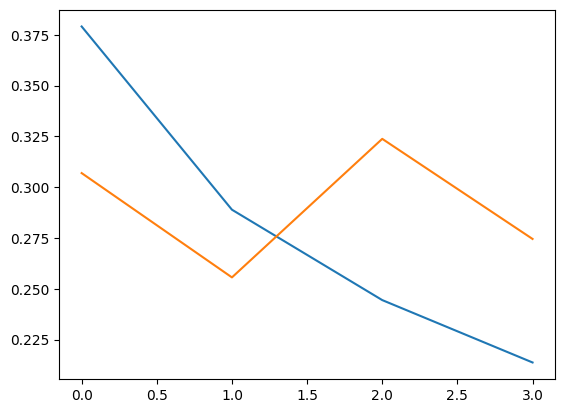

In [88]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_last'.format(out_dir)

PATH = os.path.join(test_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.savefig(os.path.join(out_dir, 'train_valid_loss.png'))

In [89]:
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, mb_m) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
#         output, _ = model(mb_x)
        output, attention_weights = model(mb_x, attention_mask=mb_m, max_len=MAX_LENGTH, opt='mean')
#         print(output)
#         print(attention_weights[4])
#         sys.exit(0)
        outputs.append(output[1].to('cpu'))
        
outputs = torch.cat(outputs)

num of iterations:  125


0it [00:00, ?it/s]C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))
C:\Users\XinZhou\AppData\Local\Temp\ipykernel_9620\1294117063.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_logits = self.softmax(final_logits)
125it [00:17,  7.05it/s]


In [90]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

log_txt("Test Accuracy: {}".format(test_accuracy))


Test Accuracy: 0.897


In [91]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[668  43]
 [ 60 229]]
Normalized confusion matrix
[[0.94 0.06]
 [0.21 0.79]]


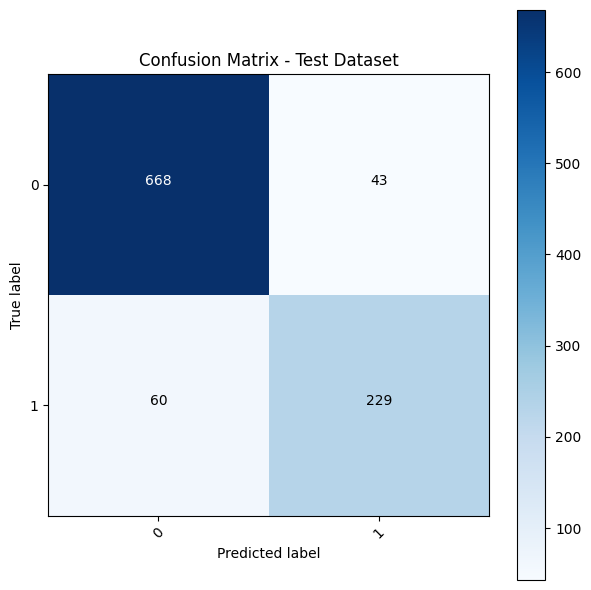

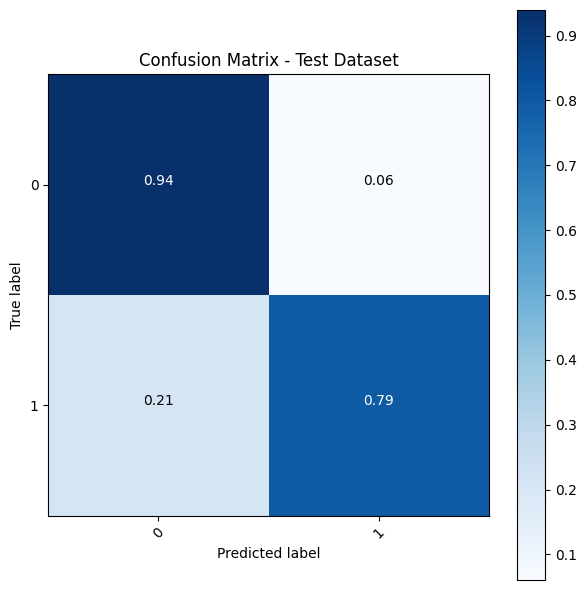

In [92]:
# from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics

def confusion_matrix_scorer(y_pred, y):
    cm = metrics.confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
        'fn': cm[1, 0], 'tp': cm[1, 1]}

cm_test = metrics.confusion_matrix(true_values, predicted_values)
print({ 'tn': cm_test[0, 0], 'fp': cm_test[0, 1],
        'fn': cm_test[1, 0], 'tp': cm_test[1, 1]})

log_txt('tn: {} - fp: {} - fn: {} - tp: {}'.format(cm_test[0, 0], cm_test[0, 1], cm_test[1, 0], cm_test[1, 1]))
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')

plt.savefig(os.path.join(out_dir, 'confusion_matrix.png'))

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

plt.savefig(os.path.join(out_dir, 'confusion_matrix_normalized.png'))